# Binary Image Classification Deep Learning Model for Malaria Parasite Detection Using TensorFlow Take 3
### David Lowe
### March 22, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Malaria Parasite Detection dataset is a binary-class classification situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: Biomedical researchers have developed a mobile application that runs on a standard Android smartphone attached to a conventional light microscope for detecting the malaria disease. The smartphone’s built-in camera acquired thin blood smear images of slides for each microscopic field of view. An expert manually annotated the slides afterward. The dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells.

From iteration Take1, we constructed a CNN model using a simple three-block VGG architecture and tested the model's performance using a held-out validation dataset.

From iteration Take2, we constructed a CNN model using the InceptionV3 architecture and tested the model's performance using a held-out validation dataset.

In this Take3 iteration, we will construct a CNN model using the ResNet50V2 architecture and test the model's performance using a held-out validation dataset.

ANALYSIS: From iteration Take1, the model's performance achieved an average accuracy score of 94.08% on the validation dataset after 20 epochs.

From iteration Take2, the model's performance achieved an average accuracy score of 95.12% on the validation dataset after 20 epochs.

In this Take3 iteration, the model's performance achieved an average accuracy score of 95.19% on the validation dataset after 20 epochs.

CONCLUSION: In this iteration, the ResNet50V2 CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: Malaria Parasite Detection

Dataset ML Model: Binary-class image classification with numerical attributes

Dataset Reference: https://lhncbc.nlm.nih.gov/LHC-publications/pubs/MalariaDatasets.html

A potential source of performance benchmark: https://doi.org/10.7717/peerj.4568 or https://doi.org/10.7717/peerj.6977

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Mar 15 17:49:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import zipfile
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.2

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=seedNum)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCH = 20
BATCH_SIZE = 64
RAW_IMAGE_SIZE = (128, 128)
TARGET_IMAGE_SIZE = (100, 100)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

NUM_CLASSES = 1
CLASS_LABELS = ['Parasitized','Uninfected']

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Define the directory locations and file names
# TRAIN_SUBSET_CSV = 'train32.csv'
# TEST_SUBSET_CSV = 'test32.csv'
# LABELS_DIR = 'staging/'
TRAIN_DIR = 'staging/cell_images/'
# TEST_DIR = 'staging/test_images/'
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.4.1


In [8]:
# Set up the parent directory location for loading the dotenv files
# Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# env_path = "/Users/david/PycharmProjects/"
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [11]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [13]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [14]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/
!rm cell_images.zip

rm: cannot remove 'cell_images.zip': No such file or directory


In [15]:
!wget https://dainesanalytics.com/datasets/tensorflow-malaria-parasite-detection/cell_images.zip

--2021-03-15 17:49:56--  https://dainesanalytics.com/datasets/tensorflow-malaria-parasite-detection/cell_images.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.225.93.61, 13.225.93.21, 13.225.93.38, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.225.93.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  97.7MB/s    in 3.5s    

2021-03-15 17:50:00 (96.3 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [16]:
STAGING_DIR = 'staging/'
!mkdir staging/

In [17]:
# Unzip and put the files into the staging folder
local_zip = 'cell_images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [18]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    print('Number of training images for', c_label, ':', len(os.listdir(training_class_dir)))
    print('Training samples for', c_label, ':', training_class_files[:10])

Number of training images for Parasitized : 13780
Training samples for Parasitized : ['C130P91ThinF_IMG_20151004_141341_cell_160.png', 'C39P4thinF_original_IMG_20150622_114804_cell_25.png', 'C39P4thinF_original_IMG_20150622_110115_cell_105.png', 'C181P142ThinF_IMG_20151127_155914_cell_183.png', 'C99P60ThinF_IMG_20150918_141857_cell_25.png', 'C99P60ThinF_IMG_20150918_141620_cell_8.png', 'C140P101ThinF_IMG_20151005_205922_cell_190.png', 'C91P52ThinF_IMG_20150821_124311_cell_29.png', 'C167P128ReThinF_IMG_20151201_105707_cell_242.png', 'C118P79ThinF_IMG_20151002_105018_cell_141.png']
Number of training images for Uninfected : 13780
Training samples for Uninfected : ['C74P35_ThinF_IMG_20150815_121324_cell_73.png', 'C155P116ThinF_IMG_20151115_143125_cell_11.png', 'C54P15thinF_IMG_20150728_102017_cell_192.png', 'C52P13thinF_IMG_20150725_125213_cell_130.png', 'C205ThinF_IMG_20151106_151711_cell_155.png', 'C82P43ThinF_IMG_20150817_123500_cell_196.png', 'C104P65ThinF_IMG_20150918_172537_cell_53.

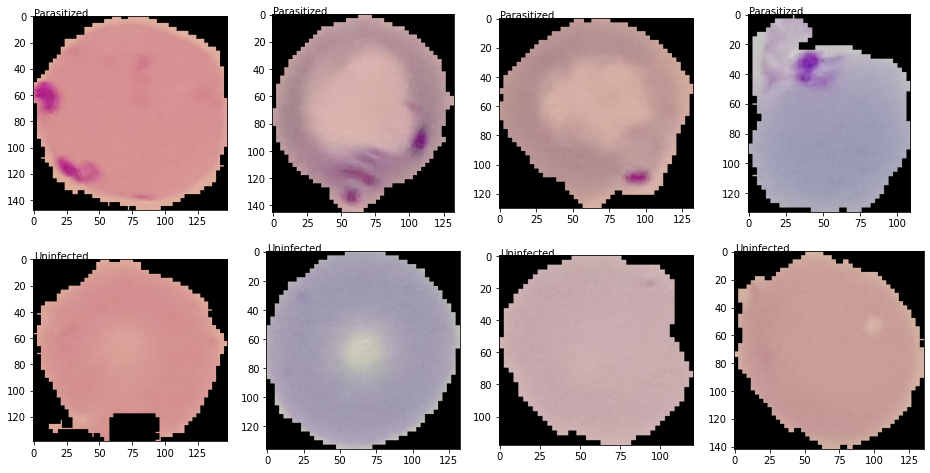

In [19]:
# Plot some training images from the dataset
nrows = 2
ncols = 4
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    for j in range(ncols):
        training_examples.append(c_label+'/'+training_class_files[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(TRAIN_DIR + img_path)
    plt.imshow(img)
plt.show()

In [20]:
datagen_kwargs = dict(rescale=1./255, validation_split=VAL_SET_SIZE)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="binary")

do_data_augmentation = False
if do_data_augmentation:
    training_datagen = ImageDataGenerator(fill_mode="constant",
                                          shear_range=0.2,
                                          zoom_range=(0.5, 1),
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          rotation_range=360,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          brightness_range=(0.75, 1.25),
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          subset='training',
                                                          shuffle=True,
                                                          seed=seedNum,
                                                          **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              subset='validation',
                                                              shuffle=False,
                                                              **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 22048 images belonging to 2 classes.
Number of image batches per epoch of modeling: 689
Loading and pre-processing the validation images...
Found 5510 images belonging to 2 classes.
Number of image batches per epoch of modeling: 173


In [21]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [22]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [23]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
#         if metric == train_loss:
#             plt.ylim([0, plt.ylim()[1]])
#         else:
#             plt.ylim([0.5, 1.1])
        plt.legend()

In [24]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.ResNet50V2(include_top=False, weights=None, input_shape=input_param, pooling='avg')
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(tf.keras.layers.Flatten())
    nn_model.add(tf.keras.layers.Dropout(0.5))
    nn_model.add(tf.keras.layers.Dense(output_param, activation=CLASSIFIER_ACTIVATION))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [25]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1, factor=0.5, min_lr=0.0000001)
reset_random(seedNum)
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(
    training_generator,
	validation_data=validation_generator,
    epochs=MAX_EPOCH,
    callbacks=[learning_rate_reduction],
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/20
689/689 [==============================] - 71s 74ms/step - loss: 0.4250 - accuracy: 0.7984 - val_loss: 0.1965 - val_accuracy: 0.9381
Epoch 2/20
689/689 [==============================] - 49s 72ms/step - loss: 0.1470 - accuracy: 0.9540 - val_loss: 0.2367 - val_accuracy: 0.9196
Epoch 3/20
689/689 [==============================] - 49s 72ms/step - loss: 0.1264 - accuracy: 0.9597 - val_loss: 0.1587 - val_accuracy: 0.9512
Epoch 4/20
689/689 [==============================] - 49s 72ms/step - loss: 0.1277 - accuracy: 0.9580 - val_loss: 0.1475 - val_accuracy: 0.9495
Epoch 5/20
689/689 [==============================] - 49s 72ms/step - loss: 0.1243 - accuracy: 0.9574 - val_loss: 0.3768 - val_accuracy: 0.9254
Epoch 6/20
689/689 [==============================] - 49s 72ms/step - loss: 0.1213 - accuracy: 0.9614 - val_loss: 0.1962 - val_accuracy: 0.9403

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/20
689/689 [==============================] - 4

In [26]:
nn_model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


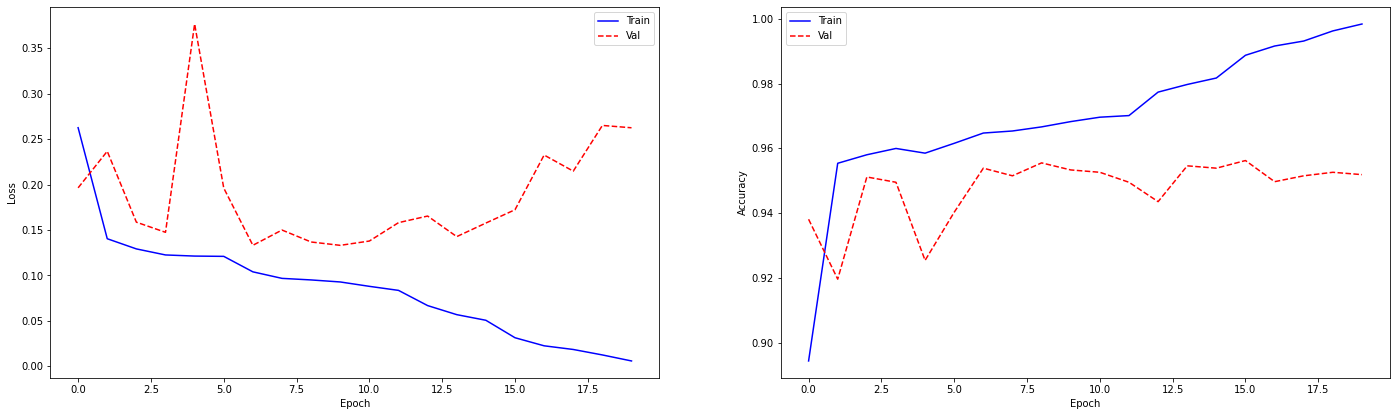

In [27]:
plot_metrics(nn_model_history)

In [28]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [29]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [30]:
# Not applicable for this iteration of modeling

In [31]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [32]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [33]:
# Not applicable for this iteration of modeling

In [34]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [35]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:17:05.205090
